adopted from https://docs.openfree.energy/en/latest/tutorials/rbfe_python_tutorial.html

In [1]:
#mamba create -n openfe openfe=1.7 -c conda-forge
#mamba activate openfe

In [2]:
%matplotlib inline
import openfe

# Two PIM1 kinase inhibitors with similar structures and binding modes

Ligand A: pdb code: 5DWR-> compound 8 (PIM447), Ki= 6 pM (ref1)

Ligand B: pdb code: 4N70-> compound 3 (ref1), compound 5c (ref2), Ki= 1pM

ref1: https://pubs.acs.org/doi/10.1021/acs.jmedchem.5b01275

ref2: https://pubs.acs.org/doi/10.1021/ml400307j

In [3]:
#To convert ligands: mol2 to sdf
from rdkit import Chem

mol = Chem.MolFromMol2File("ligandA.mol2", removeHs=False)
Chem.MolToMolFile(mol, "./output/ligandA.sdf")

mol = Chem.MolFromMol2File("ligandB.mol2", removeHs=False)
Chem.MolToMolFile(mol, "./output/ligandB.sdf")



# Setting up a relative binding free energy network
This tutorial shows how to set up an RBFE simulation with OpenFE using Python, mirroring the CLI tutorial but allowing full customization beyond the openfe plan-rbfe-network command.

## Loading the ligands

First we must load the chemical models between which we wish to calculate free energies.
In this example these are initially stored in individual (`.sdf`) molecules.
This can be loaded using the `SDMolSupplier` class from rdkit and passed to openfe.

In [4]:
from rdkit import Chem
#supp = Chem.SDMolSupplier("ligands.sdf", removeHs=False)
#ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]

# Load ligands from SDF
ligand_files = ["./output/ligandA.sdf", "./output/ligandB.sdf"]
ligands = []
for f in ligand_files:
    supplier = Chem.SDMolSupplier(f, removeHs=False)
    mol = next(iter(supplier))  # take the first molecule from the file
    if mol is None:
        raise ValueError(f" Failed to load molecule from {f}")
    ligands.append(openfe.SmallMoleculeComponent.from_rdkit(mol))

ligA, ligB = ligands

print("Loaded ligands:")
print("Ligand A:", ligA)
print("Ligand B:", ligB)
print(ligands)

Loaded ligands:
Ligand A: SmallMoleculeComponent(name=5DWR_L_PyMOL.pdb)
Ligand B: SmallMoleculeComponent(name=4N70_L_PyMOL.pdb)
[SmallMoleculeComponent(name=5DWR_L_PyMOL.pdb), SmallMoleculeComponent(name=4N70_L_PyMOL.pdb)]


## Charging the ligands

Use a single charge set per ligand for reproducibility and consistency across calculations. Here, ligands are charged with the default OpenFE method: am1bcc from ambertools, configured via OpenFFPartialChargeSettings.

In [5]:
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges

charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")

charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,  
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=charge_settings.number_of_conformers,
    nagl_model=charge_settings.nagl_model,
    processors=4
)

/home/jamal/miniforge3/envs/openfe/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=197931) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/jamal/miniforge3/envs/openfe/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=197931) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/jamal/miniforge3/envs/openfe/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=197931) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/jamal/miniforge3/envs/openfe/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=197931) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
Generating charges: 100%|█████████████████████████| 2/2 [02:16<00:00, 68.11s/it]


## Creating the `LigandNetwork`

The first step is to create a `LigandNetwork`, which is a network with small molecules as nodes, and atom mappings, the description of how to alchemically mutate between the molecules, as its edges.

The pipeline for creating a `LigandNetwork` can involve three components:

* **Atom Mapper**: proposes mappings between ligands. We will use the `LomapAtomMapper`.
* **Scorer**: evaluates mapping quality. (higher scores are better). We will use `default_lomap_scorer`.
* **Network Planner**: Creates the actual `LigandNetwork`; different network planners provide different strategies. We will create a minimal spanning network with the `generate_minimal_spanning_network` method.

Different planners or components can be substituted; a minimal spanning network needs scores, while a radial one needs a central ligand.


In [6]:
mapper = openfe.LomapAtomMapper(max3d=2.0, threed=True,element_change=True)# element_change=:False, max3d=1.0
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

In [7]:
ligand_network = network_planner(
    ligands=charged_ligands,
    mappers=[mapper],
    scorer=scorer
)

Now we can look at the overall structure of the `LigandNetwork`:

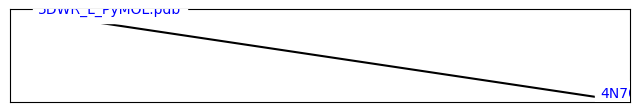

In [8]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

We can also inspect the individual atom mappings:

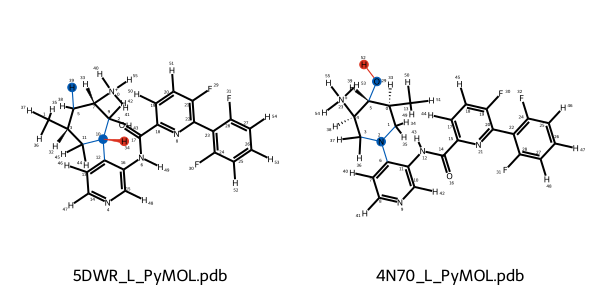

In [9]:
# get the first edge; it automatically displays in a Jupyter notebook
mapping = next(iter(ligand_network.edges))
mapping

In [10]:
mapping.view_3d()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

To get the score for this mapping, we inspect its `annotations` attribute. 

In [11]:
# higher score is better
mapping.annotations

{'score': 0.8607079764250578}

You can output the ligand network to the same `graphml` format as we saw in the CLI tutorial with the following:

In [12]:
with open("./output/ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

# Receptor preparation

5DWR includes a Sep resdidue that should be mutated back to Ser by tools like PyMOL.
Then, for automatic preparation:


In [16]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile

fixer = PDBFixer(filename='receptor_raw.pdb')
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.0)

with open('./output/receptor_prepared.pdb', 'w') as f:
    PDBFile.writeFile(fixer.topology, fixer.positions, f)

from openfe import ProteinComponent, SmallMoleculeComponent

# Read the protonated, cleaned receptor
receptor = ProteinComponent.from_pdb_file("./output/receptor_prepared.pdb")
print("Receptor:", receptor)

Receptor: ProteinComponent(name=)


## Creating a single `Transformation`

The LigandNetwork defines ligand connections only—it lacks environment and protocol details.
That information is added in a Transformation, representing one simulation leg.
Each network edge produces two Transformations: one for the complex and one for solvent.
Here, we illustrate creating the solvent leg for a selected ligand pair.

### Creating `ChemicalSystem`s

The `Component`s are joined in a `ChemicalSystem`, which describes all the particles in the simulation.

In [17]:
# defaults are water with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [19]:
protein = openfe.ProteinComponent.from_pdb_file("./output/receptor_prepared.pdb")

In [20]:
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent,
    'protein': protein
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent,
    'protein': protein    
})

### Creating a `Protocol`

In [21]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
settings = RelativeHybridTopologyProtocol.default_settings()
settings.thermo_settings.temperature  # display default value
from openff.units import unit

# change the value
settings.thermo_settings.temperature = 310.0 * unit.kelvin

We use the default settings with an adapted solvent padding for the complex phase to avoid adding too many waters.

In [22]:
# Create a protocol for the solvent legs using default settings
solvent_protocol = RelativeHybridTopologyProtocol(RelativeHybridTopologyProtocol.default_settings())

# Create a prrotocol for the complex legs with a reduced solvent padding
complex_settings = RelativeHybridTopologyProtocol.default_settings()
complex_settings.solvation_settings.solvent_padding = 1 * unit.nanometer
complex_protocol = RelativeHybridTopologyProtocol(complex_settings)

### Creating the `Transformation`

Once we have the mapping, the two `ChemicalSystem`s, and the `Protocol`, creating the `Transformation` is easy:

In [23]:
# Here we assume we are creating a transformation for a complex leg
transformation = openfe.Transformation(
    systemA,
    systemB,
    complex_protocol,
    mapping=mapping,
)

The Transformation links systemA and systemB via the mapping and chosen protocol, defining both systems, their correspondence, and the simulation setup.

## Creating the `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each leg of the campaign. We'll loop over all the mappings, and then loop over the legs. In that inner loop, we'll make each transformation.

In [24]:
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        if leg == 'complex':
            # If this is a complex transformation we use the complex protocol
            # and add in the protein to the chemical states
            protocol = complex_protocol
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        else:
            # If this is a solvent transformation we just use the solvent protocol
            protocol = solvent_protocol
        
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        prefix = "rbfe_"  # prefix is only to exactly reproduce CLI
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping=mapping,
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

## Writing the `AlchemicalNetwork` to disk

We'll write out each transformation to disk, so that they can be run independently using the `openfe quickrun` command:

In [25]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.to_json(transformation_dir / f"{transformation.name}.json")

In [26]:
!ls transformations/

rbfe_5DWR_L_PyMOL.pdb_complex_4N70_L_PyMOL.pdb_complex.json
rbfe_5DWR_L_PyMOL.pdb_solvent_4N70_L_PyMOL.pdb_solvent.json


/home/jamal/miniforge3/envs/openfe/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=197931) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Each of these individual `.json` files contains a `Transformation`, which contains all the information to run the calculation.  These could be farmed out as individual jobs on a HPC cluster. These files are identical to what were created in setup stage of the CLI tutorial; for details on running them, follow from the section on running simulations in the CLI tutorial

# Simulation

adopted from openfe quickrun path/to/transformation.json -o results.json -d working-directory

For a single run:

openfe quickrun path/to/transformation.json -o results.json -d working-directory

# Gathering the results

# In CLI
#openfe gather results/ --report dg -o final_results.tsv
#For two ligands:
openfe gather results/ --report raw -o per_edge_results.tsv 

In [29]:
import pandas as pd

df = pd.read_csv("./output/per_edge_results.tsv", sep="\t")
print(df.head(20))

        leg          ligand_i          ligand_j  DG(i->j) (kcal/mol)  \
0   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -24.4   
1   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -24.4   
2   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -24.2   
3   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -24.2   
4   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -24.4   
5   complex  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -23.9   
6   solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.9   
7   solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.8   
8   solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.9   
9   solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.5   
10  solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.6   
11  solvent  5DWR_L_PyMOL.pdb  4N70_L_PyMOL.pdb                -22.9   

    MBAR uncertainty (kcal/mol)  
0                           0

# Experimental vs Simulation (PIM1, compounds 5DWR vs 4N70)

Experiment (enzyme Ki): compound 4N70 1 pM vs compound 5DWR 6 pM → ~6× tighter for 4N703. ⇒ ΔΔG(exp, 5DWR → 4N70) ≈ −1.06 kcal/mol.

Calculated FEP (5DWR → 4N70): ΔΔG = −1.48 ± 0.11 kcal/mol → ~12× tighter for 4N70.